In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
import pandas as pd
import xarray as xr
import glob
import utils
import scipy.stats as stats
import pickle
import faceted
from fair.forcing.ghg import meinshausen2020

/home/tarshish/micromamba/envs/zec/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def compute_final_forcing(f):

    GtCO2_to_ppm = f.species_configs.concentration_per_emission.sel(specie="CO2")
    preindustrial_concentrations =  f.concentration.isel(timebounds=0)
    Af = f.species_configs.partition_fraction.sel(specie="CO2", gasbox=0)
    final_concentrations = preindustrial_concentrations + GtCO2_to_ppm*Af*f.cumulative_emissions.sel(specie="CO2")
    final_concentrations = final_concentrations.transpose("timebounds", "scenario", "config", "specie")
    Ff_CO2 = xr.ones_like(final_concentrations.sel(specie="CO2"))*np.nan
    for i_timepoint in np.arange(f._n_timepoints):
        Ff_CO2[i_timepoint,...] = meinshausen2020(                                                    
                                final_concentrations.values[i_timepoint+1:i_timepoint+2,...],        
                                f.species_configs.forcing_reference_concentration.values[None, None, ...]              
                                * np.ones(                                                          
                                    (1, f._n_scenarios, f._n_configs, f._n_species)        
                                ),       
                                f.species_configs.forcing_scale.values[None, None, ...]*(1 + f.species_configs["tropospheric_adjustment"].data),
                                f.species_configs.greenhouse_gas_radiative_efficiency.values[None, None, ...],         
                                f._co2_indices,                                                  
                                f._ch4_indices,                                                  
                                f._n2o_indices,                                                  
                                f._minor_ghg_indices,                                            
                    )[0,...,2]
    Ff = Ff_CO2 + f.forcing.sel(specie="Land use")
    return Ff

In [3]:
def compute_disequilibria(path):
    with open(path, "rb") as file:                                                                            
        f = pickle.load(file)    
    
    lamb = f.climate_configs.ocean_heat_transfer.isel(layer=0)
    Fze = f.forcing_sum
    Teq = Fze/lamb 
    Tnow = f.temperature.isel(layer=0)
    Ff = compute_final_forcing(f)
    forcing_dis = Ff/Fze
    thermal_dis = Tnow/Teq
    thermal_dis.name = "thermal_dis"
    forcing_dis.name = "forcing_dis"
    ds = xr.merge([thermal_dis, forcing_dis])
    ds = ds.median("config")
    return ds    

In [5]:
utils.set_plot_configs(plt, fsize=8)

In [6]:
results_dir = utils.get_path('results')
datasets_dir = utils.get_path('datasets')

In [7]:
# co2_emissions_21_century = (f.emissions.sel(specie="CO2 FFI") + f.emissions.sel(specie="CO2 AFOLU")).sel(timepoints=slice(2000,2100)).median("config")
# net_zero_times = co2_emissions_21_century.timepoints[abs(co2_emissions_21_century).argmin(dim="timepoints")] - .5

In [8]:
files = glob.glob(results_dir+"/fair/*_net-zero-zec.pkl")

dss = []
for path in files:
    ds = compute_disequilibria(path)
    dss.append(ds)

In [9]:
ds = xr.merge(dss)

In [10]:
ds = ds.sel(timebounds=slice(2000,2100))

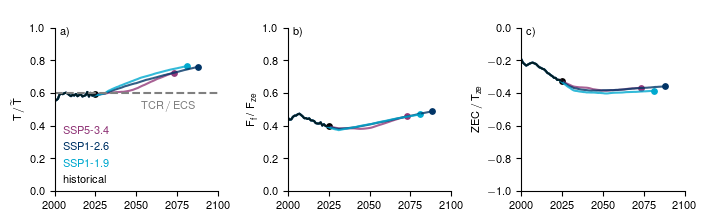

In [35]:
# Assuming faceted and all relevant libraries are already imported as in your script
fig, axes = faceted.faceted(1, 3, width=7, aspect=1.0, bottom_pad=.3, left_pad=.5,
                            top_pad=.1, right_pad=.2, internal_pad=.7, 
                            sharey=False)
colors = []
i = 0
for scenario in ds.scenario.values[::-1]:
    net_zero_time = int(utils.get_net_zero_GHG_time(scenario))
    data = ds.sel(scenario=scenario).sel(timebounds=slice(2000,net_zero_time))
    zec = data.forcing_dis/data.thermal_dis - 1

    data.thermal_dis.plot(ax=axes[0], color=utils.get_color(scenario), 
                                                 alpha=.8, label=utils.get_title(scenario))
    data.forcing_dis.plot(ax=axes[1], color=utils.get_color(scenario),
                                                 alpha=.8, label=utils.get_title(scenario))    
    zec.plot(ax=axes[2], color=utils.get_color(scenario), alpha=.8, label=utils.get_title(scenario))

    axes[0].scatter(net_zero_time, data.thermal_dis.sel(timebounds=net_zero_time), color=utils.get_color(scenario),
                    s=15)
    axes[1].scatter(net_zero_time, data.forcing_dis.sel(timebounds=net_zero_time), color=utils.get_color(scenario),
                    s=15)
    axes[2].scatter(net_zero_time, zec.sel(timebounds=net_zero_time), color=utils.get_color(scenario),
                    s=15)

    axes[0].text(2005, .35-i, utils.get_title(scenario), color=utils.get_color(scenario), ha="left")
    i += .1 
    
axes[0].axhline(.6, color="grey", linestyle="dashed")
axes[0].text(2070, .52, "$\mathrm{TCR}\,/\,\mathrm{ECS}$", ha="center", va="center", color="grey")

axes[0].set_ylim([0,1])
axes[1].set_ylim([0,1])
axes[2].set_ylim([-1,0])

for ax in axes:
    ax.set_title(" " )
    ax.set_xlim([2000,2100])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel(" ")

for ax, label in zip(axes, ["a", "b", "c"]):
    ax.text(.03, .95, f"{label})", transform=ax.transAxes)

axes[0].set_ylabel("$\mathrm{T \,}/\\widetilde{\, \mathrm{T}}$")
axes[1].set_ylabel("$\mathrm{F}_\mathrm{f}\,$/$\,\,\mathrm{F}_\mathrm{ze}$")
axes[2].set_ylabel("$\mathrm{ZEC\,}/\,\mathrm{T}_\mathrm{ze}$")

fig.savefig(results_dir+"/figures/sfig_diseq.pdf")

In [12]:
# # Assuming faceted and all relevant libraries are already imported as in your script
# fig, axes = faceted.faceted(1, 3, width=7, sharey=False,
#                              aspect=1.0, bottom_pad=.5, left_pad=.6,
#                              top_pad=.3, right_pad=1.2, internal_pad=.7)
# colors = []
# for scenario in f.scenarios:
#     f.forcing_sum.sel(scenario=scenario).median("config").sel(timebounds=slice(2000,2100)).plot(ax=axes[0], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])

#     forcing_net_zero = f.forcing_sum.sel(scenario=scenario).median("config").sel(timebounds=net_zero_times.sel(scenario=scenario).values)
    
#     axes[0].scatter(forcing_net_zero.timebounds.values, 
#                     forcing_net_zero.values, 
#                  zorder=5, color=ar6_colors[scenario]) 


#     Ff.sel(scenario=scenario).median("config").sel(timebounds=slice(2000,2100)).plot(ax=axes[1], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])
#     f.temperature.isel(layer=0).sel(scenario=scenario).median("config").sel(timebounds=slice(2000,2100)).plot(ax=axes[2], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])

#     #f.emissions.sel(specie="CO2").sel(scenario=scenario).median("config").sel(timepoints=slice(2000,2100)).plot(ax=axes[1], color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])
#     colors.append(ar6_colors[scenario])

# axes[1].axhline(.6, color="grey", linestyle="dashed")
# axes[1].text(2085, .63, "TCR/ECS", ha="center", va="center", fontsize=10, color="grey")

# for ax in axes:
#     #ax.set_ylim([.1,.9])
#     ax.set_title(" " )
#     ax.set_xlim([2000,2100])
#     ax.spines['right'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     ax.grid()
#     #ax.set_xlabel(" ")

# axes[0].text(.03, .95, "a)", transform=axes[0].transAxes)
# axes[1].text(.03, .95, "b)", transform=axes[1].transAxes)
# axes[1].legend(fontsize=10, handlelength=.6, handletextpad=.4, frameon=False, loc="lower right", labelcolor=colors)
               
# axes[0].set_ylabel("transient forcing")
# axes[1].set_ylabel("final forcing")

In [13]:
# fig, (axis,) = faceted.faceted(1,1, aspect=1, width=4)

# for scenario in f.scenarios:

#     y = f.forcing_sum.sel(scenario=scenario).sel(timebounds=slice(None, net_zero_times.sel(scenario=scenario).values)).median("config")
#     x = f.cumulative_emissions.sel(specie="CO2", scenario=scenario).sel(timebounds=slice(None, net_zero_times.sel(scenario=scenario).values)).median("config")

#     axis.plot(x, y, color=ar6_colors[scenario], alpha=.8, label=fancy_titles[scenario])

# axis.set_ylim(0,None)
# axis.set_xlim(0,None)
# axis.set_xlabel("$C_{emit}$\,\,[GtC]")
# axis.set_ylabel("$F\,\,$ [W/m$^2$]")
# fig.savefig("/home/tarshish/Documents/research/ZEC/results/forcing_vs_Cemit.pdf", bbox_inches="tight")

In [14]:
# def remove_CO2(f):
#     delta_f = f.forcing_sum - f.forcing.sel(specie="CO2") 
#     return delta_f

In [15]:
# f.cumulative_emissions.isel(specie=2).sel(timebounds=slice(2024,2060)).median("config").plot.line(x="timebounds")

In [16]:
# fig, (axis,) = faceted.faceted(1,1)

# y = f.temperature.isel(layer=0, scenario=0).sel(timebounds=slice(2024,2060))
# x = f.temperature.sel(timebounds=slice(2024,2060)).timebounds

# utils.plot_median(x,y,axis,spread=[25,75])

# axis.set_xlabel(" ")
# axis.set_title(" ")